In [30]:
from bentPlumeAnalyser import (plume_trajectory as plumeTrajectory,
                               dist_along_path as distAlongPath,
                               plume_angle as plumeAngle,
                               true_location_width as trueLocationWidth)
                                
from fumarolePlumeModel import *
from scipy.io.matlab import loadmat
from itertools import product
from matplotlib.colors import LogNorm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
import json

# Set numpy options, notably for the printing of floating point numbers
np.set_printoptions(precision=6)

# Set matplotlib options
mpl.rcParams['figure.dpi'] = 300

In [31]:
def integrator(V0, p):
    # Initialise an integrator object
    r = ode(derivs).set_integrator('lsoda', nsteps=1e6)
    r.set_initial_value(V0, 0.)
    r.set_f_params(p)
    
    # Define state vector and axial distance
    V = []    # State vector
    s = []    # Axial distance
    V.append(V0)
    s.append(sexp[0])
    
    # Define the individual variables - these will be calculated at run time
    Q, M, F, theta = 0., 0., 0., 0.
    Q = np.float64(Q0)
    M = np.float64(M0)
    F = np.float64(F0)
    theta = np.float64(theta0)
    
    ####################################

    # Integrate, whilst successful, until the domain size is reached
    ind = 0
    while r.successful() and r.t < t1 and M >= 0.:
        dt = dsexp[ind]
        r.integrate(r.t + dt)
        V.append(r.y)
        s.append(r.t)
        Q, M, F, theta = r.y
        ind += 1
    s = np.array(s)
    V = np.float64(np.array(V))
    return s, V

In [32]:
exptNo   = 3
plotResults = True

# Read analysed experimental data from file
fname    = './data/ExpPlumes_for_Dai/GCTA_plumeData.xlsx'
exptData = pd.read_excel(fname, sheet_name='exp%02d' % exptNo)

# Display the first 5 lines of the data frame
exptData.head()

,axisLocn_x,axisLocn_y,distAlongAxis,plumeAngle,plumeWidth
0,-0.082073,0.122375,0.147349,1.510677,0.277366
1,0.079714,1.257440,1.293886,1.449785,0.319537
2,0.024641,2.499398,2.537064,1.176742,0.650992
3,1.443832,4.561191,5.040081,0.783431,1.048499
4,2.855947,5.234923,6.604684,0.565428,1.329422


In [33]:
## DEFINE THE DISTANCE ALONG THE AXIS, THE ANGLE AND THE WIDTH OF THE PLUME
# sexp  = exptData.distAlongAxis
# thexp = exptData.plumeAngle
# bexp  = exptData.plumeWidth

path = './data/ExpPlumes_for_Dai/exp%02d/' % exptNo

skip = 10 

#with open(path + 'exp%02d_initGuess.json' % exptNo) as f:
    #data = json.load(f)
#p = np.array(data['data'])

#data = np.flipud(loadmat(path + 'gsplume.mat')['gsplume'])
xexp = loadmat(path + 'xcenter.mat')['xcenter'][0]
zexp = loadmat(path + 'zcenter.mat')['zcenter'][0]
Ox, Oz = (xexp[0], zexp[0])
pPixels = np.array([xexp, zexp]).T[::skip]

data, xexp, zexp, extent = loadExptData(exptNo)
if data.mean() < .5:
    data = 1. - data
p = np.array([xexp, zexp]).T[::skip]

#xexp = (xexp - Ox) / scaleFactor
#zexp = (Oz - zexp) / scaleFactor
#pPixels = p.copy() * scaleFactor
#pPixels[:,0] += Ox
#pPixels[:,1] -= Oz
#pPixels[:,1] *= -1

# Calculate angle, width and distance along plume and errors
thexp, sig_thexp = plumeAngle(p[:,0], p[:,1], errors=[1/scaleFactor]*2)
_, bexp, sig_p, sig_bexp = trueLocationWidth(data, None, pPixels, scale_factor=scaleFactor, errors=[1/scaleFactor], plotting=False)
sexp      = distAlongPath(p[:,0], p[:,1])
bexp     /= scaleFactor
sig_bexp /= scaleFactor
bexp[0]   = 0.55 / 2
thexp[0]  = np.pi / 2

/home/david/Modelling/fumarolePlumeModel/bentPlumeAnalyser.py:419: RuntimeWarning: invalid value encountered in sqrt
  plume_width_err.append(np.sqrt(np.diag(pcov[-1])))


In [34]:
# Import table of experimental conditions
GCTA = pandas.read_excel('./data/ExpPlumes_for_Dai/TableA1.xlsx', sheet_name='CGSdata', skiprows=2, 
                         names=('exptNo', 'rhoa0', 'sig_rhoa0', 'N', 'sig_N', 'rho0', 'sig_rho0', 'U0', 'sig_U0', 'W', 'sig_W', 
                                'gp', 'sig_gp', 'Q0','sig_Q0', 'M0', 'sig_M0', 'F0', 'sig_F0', 'Ri_0', 'sig_Ri_o', 'W*','sig_W*'))

# Extract densities of ambient and plume, and calculate g' at the source
expt  = GCTA[GCTA['exptNo'] == 3]
rhoa0 = expt['rhoa0'][0]
rho0  = expt['rho0'][0]
g = 981 #cm/s²
gp0   = (rhoa0 - rho0) / rhoa0 * g

parameters = pandas.read_excel('./data/ExpPlumes_for_Dai/TableA1.xlsx', sheet_name='CGSparameters')
b0theoretical = parameters[parameters['property'] == 'nozzleSize']['value'].values[0]
u0theoretical = expt['U0'].values[0]

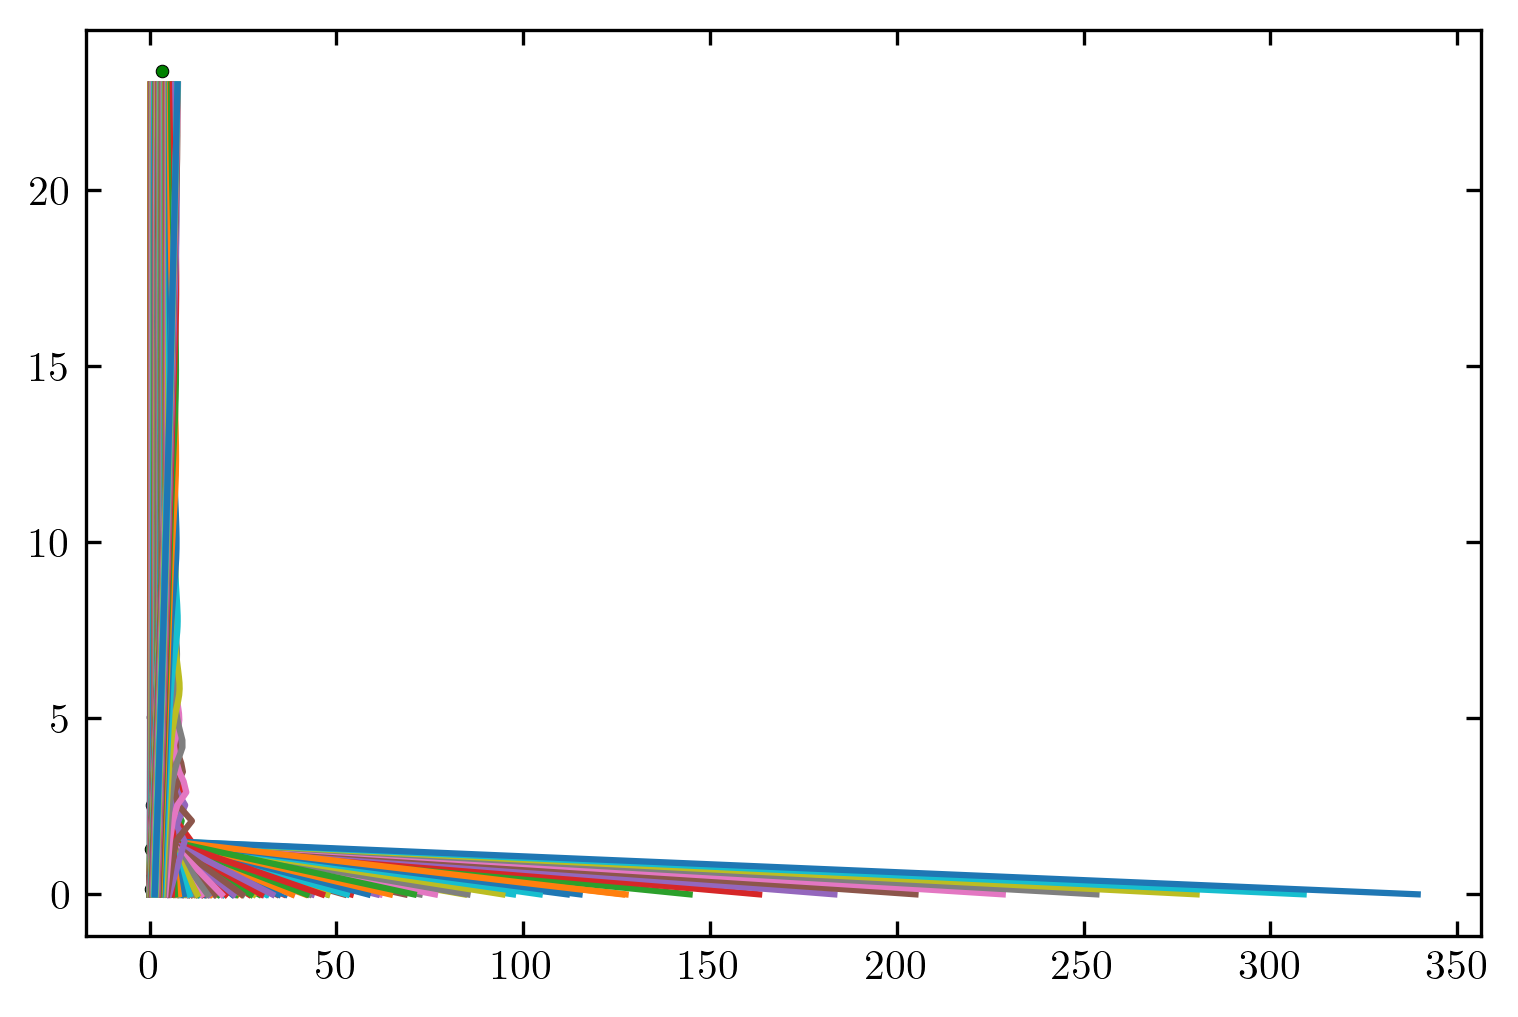

In [35]:
# Load initial conditions for a given experiment, run the model for those conditions 
# and then compare model and experimental data
fig, ax = plt.subplots()
ax.plot(exptData.plumeWidth, exptData.distAlongAxis, 'g.', label='natural')
V0, p = loadICsParameters(pathname, exptNo, alpha=0.05, beta=0, m=2)

#p = (0.05, 0.5, .012, 2., 0.)
nGrid = 31   # Number of grid points
b0Vec = np.linspace(.05, 2, nGrid) #cm
u0Vec = np.linspace(5, 30, nGrid) #cm/s
Q0Vec = u0Vec * b0Vec**2 #cm3/s
M0Vec = Q0Vec * u0Vec #cm4/s2

theta0 = np.pi / 2

objFn, initialConds = [], []

# Set integration domain and step size
t1 = sexp.max()    # Domain of integration
dsexp = np.diff(sexp) # Discretise the distance along plume axis - use as integration steps 

sequence = [Q0Vec, M0Vec]

for (Q0, M0) in list(product(*sequence)):
    F0 = Q0 * gp0
    V0 = [Q0, M0, F0, theta0]
    
    # Call the 'integrator' function (defined above) to solve
    # the model
    s, V = integrator(V0, p)
    Q, M, F, theta = [V[:,i] for i in range(4)]    
    
    #######################################
    
    b  = Q / np.sqrt(M) / np.sqrt(2) # Factor of sqrt{2} to correspond with top-hat model
    u  = M / Q
    gp = F / Q
    
    Vexp = np.array([thexp]).ravel(order='C')
    Vsyn = np.array([theta]).ravel(order='C')
    sigV = np.array([sig_thexp]).ravel(order='C')
    CovV = np.diag(sigV**2)

    objFn.append(objectiveFn(Vexp, Vsyn, cov=CovV, p=p))
    initialConds.append(V0)
    ax.plot(b, s, '-', label='Model %.4f %.4f %.4f' % (Q0, M0, F0))
    
#ax.legend(loc=5)
# ax.set_xlim((0, 25))

# Transform initialConds and objFn from lists to arrays, 
# reshaping the latter 
initialConds = np.array(initialConds)
objFn = np.array(objFn).reshape((-1, nGrid))

In [ ]:
#a = np.arange([b0Vec],[u0Vec])# columns= list('bs'), dtype=float)
#mu,sigma = 0, 0.1
#creating a noise with the same dimension as the dataset
#noise = np.random.normal (b0Vec, u0Vec)
#print (noise)
#signal = a + noise 
#print (a)
#plt.plot(a,signal)
#plt.show

In [ ]:
#Add some random noise 

#noise = np. random.normal (0,1,100)
#plt.subplot(2,1,1)
#plt.title('with noise')
#plt.show

### Plot the objective function for the parameter space that we have calculated

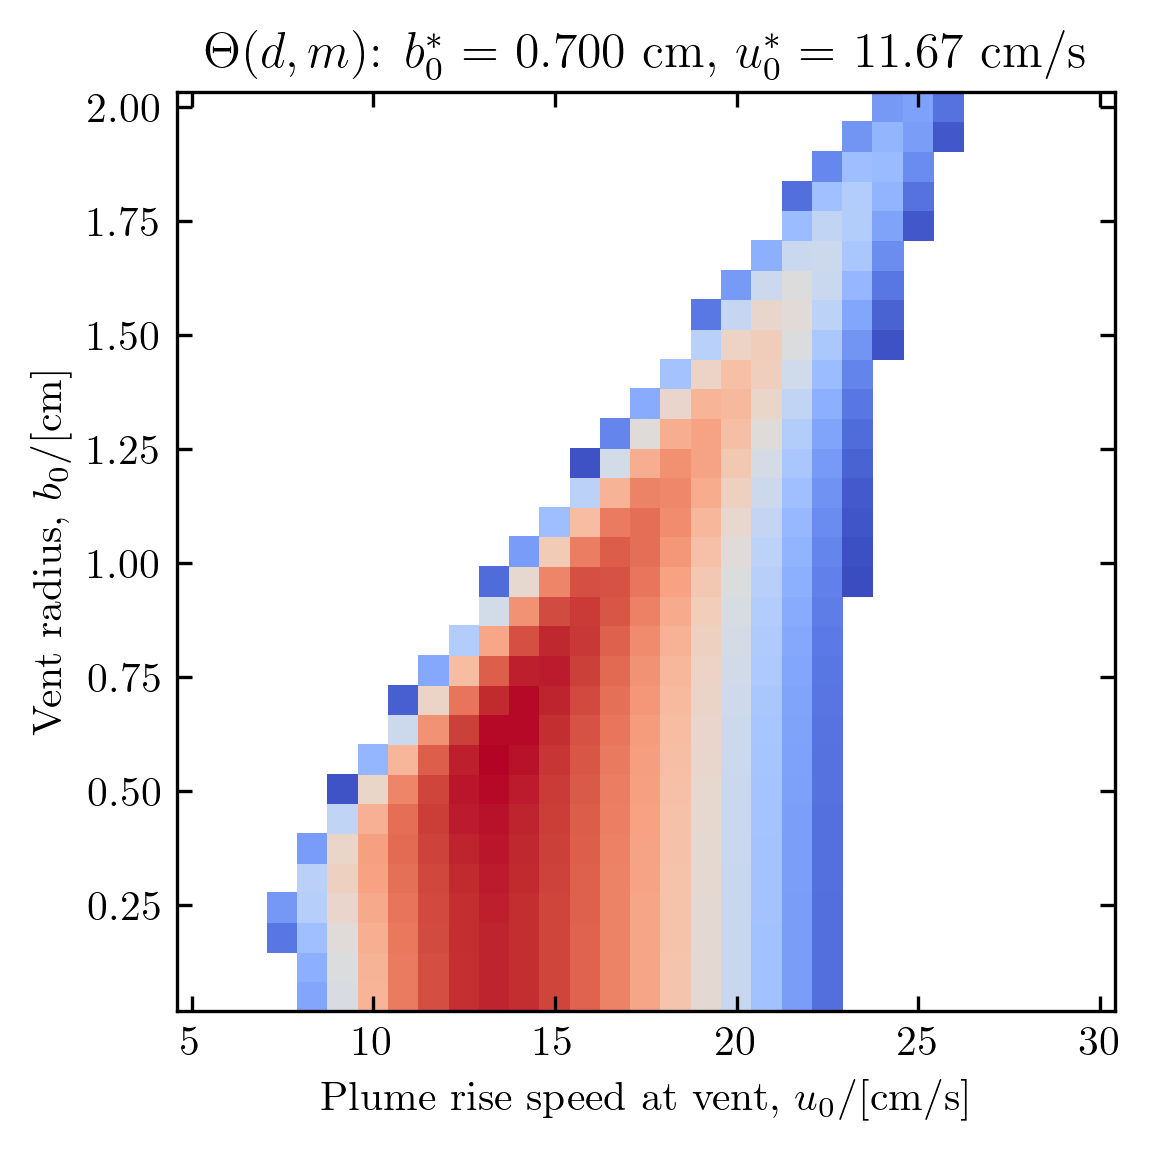

In [43]:
## Optimal values
cm = 1/2.54
fig = plt.figure(figsize=(10*cm, 10*cm))
ui, bi = np.where(objFn == objFn.max())
bOpt = b0Vec[bi[0]]
uOpt = u0Vec[ui[0]]

LN = LogNorm()
plt.pcolor(u0Vec, b0Vec, objFn, norm=LN)
hY = plt.ylabel(r'Vent radius, $b_0$/[cm]')
hX = plt.xlabel(r'Plume rise speed at vent, $u_0$/[cm/s]')
hL = plt.title((r'$\Theta(d, m)$: ' + 
              '$b^*_0$ = %.3f cm, $u^*_0$ = %.2f cm/s' % (bOpt, uOpt)))


# plt.plot(uOpt, bOpt, 'wo', ms=8, label='Locn. max. prob.')

fig.tight_layout()
plt.savefig('images/ProbabilityDistribution_b0u0.png', dpi=300)

# plt.pcolor(Q0Vec, M0Vec, objFn, norm=LN)
# hX = plt.xlabel(r'$Q_0$')
# hY = plt.ylabel(r'$M_0$')
# hL = plt.title(r'Probability distribution, $\Theta(d, m)$')

In [ ]:
### Now extract

In [ ]:
# Calculate the model predictions
# Extract the plume parameters from the state vector
Q     = V[:,0]
M     = V[:,1]
F     = V[:,2]
theta = V[:,3]

# Calculate more intuitive plume parameters (width, speed and specific gravity)
b  = Q / np.sqrt(M0)
u  = M / Q
gp = F / Q

xmod, zmod = [0.], [0.]
ds_ = np.diff(s)
for (ds, th) in zip(ds_, theta):
    xmod.append(xmod[-1] + ds * np.cos(th))
    zmod.append(zmod[-1] + ds * np.sin(th))

In [ ]:
# Directly compare the plume width and angle for experiment and model
# First, the model data has to be interpolated onto the same grid as the experimental data
from scipy.interpolate import interp1d
# Plume width
f = interp1d(s, b)
bmod = f(sexp)
# Plume angle
f = interp1d(s, theta)
thmod = f(sexp)

# Calculate an "objective function" which measures the misfit between data and model
# Initially, only use width and angle
Vexp = np.array([bexp, thexp]).T
Vmod = np.array([bmod, thmod]).T
sigV = np.array([sig_bexp, sig_thexp]).T

# The residual between experimental and model data
res = (Vexp - Vmod) / sigV
objFn = objectiveFn(Vexp.ravel(), Vmod.ravel(), np.diagflat(sigV.ravel())**2, p)

In [212]:
CovV

array([[5.850994e-05, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 2.127405e-04, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 7.884648e-04, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 3.955147e-02,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        3.953137e-02, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 3.951054e-02]])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

### Plot the model solution over the experimental image and data
# Model solution trajectory
xmod, zmod = [0.], [0.]
ds_ = np.diff(sexp)
for (ds, th) in zip(ds_, theta):
    xmod.append(xmod[-1] + ds * np.cos(th))
    zmod.append(zmod[-1] + ds * np.sin(th))
    
# On an image of the experimental plume, show the plume trajectories for
# 1) GCTA, 2) our initial guess, 3) the model solution
ax[0].imshow(data, extent=extent, cmap=plt.cm.gray)
ax[0].invert_yaxis()
ax[0].set_xlabel(r'$x$/[cm]')
ax[0].set_ylabel(r'$z$/[cm]')
# 1) GCTA
ax[0].plot(xexp, zexp, 'r-', label='GCTA', lw=2)
# 2) our initial guess
ax[0].plot(exptData.axisLocn_x, exptData.axisLocn_y, 'r--', label='Init. guess', lw=2)
# 3) the model solution
ax[0].plot(xmod, zmod, 'g--', label='model', lw=2)
ax[0].set_xlim((extent[:2]))
ax[0].legend(loc=2)

### Plot optimal values
ui, bi = np.where(objFn == objFn.max())
bOpt = b0Vec[bi[0]]
uOpt = u0Vec[ui[0]]

im = ax[1].pcolor(b0Vec, u0Vec, np.log10(objFn / objFn.sum()))
hX = ax[1].set_xlabel(r'$b_0$')
hY = ax[1].set_ylabel(r'$u_0$')
hL = ax[1].set_title(r'$b^*_0$ = %.3f cm, $u^*_0$ = %.2f cm/s' % 
                     (bOpt, uOpt))

ax[1].plot(bOpt, uOpt, 'r.', ms=8, label='Values with max. prob.')
ax[1].plot(b0theoretical, u0theoretical, 'k.', ms=8, label='Supposed values')

cbar = fig.colorbar(im)
cbar.set_label(r'$\log_{10}{\Theta(d,m)}$')

ax[1].legend(loc=4)
fig.savefig('ProbabilityDistribution_b0u0.png', dpi=300)

#ax[1].plot(res[:,0], sexp, '-', label=r'$(b_{\mathrm{exp}} - b_{\mathrm{mod}})/\sigma_b$/[cm]')
#ax[1].plot(res[:,1], sexp, '-', label=r'$(\theta_{\mathrm{exp}} - \theta_{\mathrm{mod}})/\sigma_{\theta}$/[-]')
#ax[1].legend(loc=1, fancybox=True, framealpha=.8)
#ax[1].grid()
#ax[1].set_ylabel('Distance along plume axis, s/[cm]')

#ax[1].set_title('Objective fn: %.3f' % objFn)

In [227]:
objFn

[]

(*Left*) Image of experimental plume with calculated and estimated trajectories.  (*Right*) Difference between experimental (guessed) and model solutions as a function of the distance along the plume axis.  

# To do:
- Make a grid of possible initial conditions and run the model for each case
- Compare these solutions against the experimental data, computing an objective funtion for each case
- Identify which cases produce minima in the objective function

In [10]:
# Uncomment the following line to transform this notebook into a latex file
!jupyter nbconvert --to latex plumeAnalyser.ipynb

[NbConvertApp] Converting notebook plumeAnalyser.ipynb to latex
[NbConvertApp] Support files will be in plumeAnalyser_files/
[NbConvertApp] Making directory plumeAnalyser_files
[NbConvertApp] Writing 36000 bytes to plumeAnalyser.tex


In [11]:
# Now run pdflatex plumeAnalyser from the command line